In [ ]:
# If used in colab, these packages are needed
!pip install transformers
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Import necessary libraries
 ---

In [ ]:
import numpy as np
import pandas as pd
import random
import os
from os.path import join

os.environ['TF_DETERMINISTIC_OPS'] = str(1) # For deterministic calculation

import pickle # Save object
import torch

# Set various seeds to 0 to get reproducible results
os.environ['PYTHONHASHSEED'] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

import matplotlib.pyplot as plt # Plotting
from sklearn.model_selection import StratifiedKFold # Generate folds
from sklearn import metrics # Calcluating scores for evaluation
from transformers import AutoTokenizer, AutoModelForMaskedLM
import gc

 General setup
 ---

In [ ]:
# Model version
version = "v1"

# Paths to various directories and files
path_base = "/content/drive/MyDrive/swp"
path_data = os.path.join(path_base, "data")
path_checkpoints = "/content/checkpoints"
path_models = os.path.join(path_base, "models", version)
path_prep = os.path.join(path_data, version)
path_cache = os.path.join(path_base, "cache")

path_train = os.path.join(path_data, "sentences_train.tsv")
path_test = os.path.join(path_data, "sentences_test.tsv")

# Read data
train = pd.read_csv(path_train, sep='\t')
test = pd.read_csv(path_test, sep='\t')

class_names = np.array(["Description", "Feelings", "Evalutation", "Analysis", "Conclusion", "Action Plan"])


In [ ]:
# Generate binary encoded option vectors
train_options = np.zeros((len(train), 6), dtype=np.int32)
for i, options in enumerate(train['options']):
    options_indices = [*map(int, options.split(','))]
    train_options[i, options_indices] = 1

test_options = np.zeros((len(test), 6), dtype=np.int32)
for i, options in enumerate(test['options']):
    options_indices = [*map(int, options.split(','))]
    test_options[i, options_indices] = 1

Generate plots
---
Generate plots for the final class distribution and the options distribution. Each for train and test set.

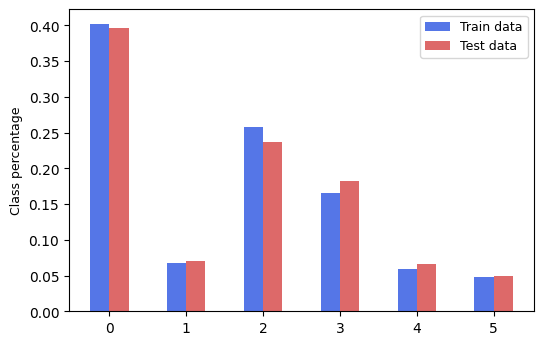

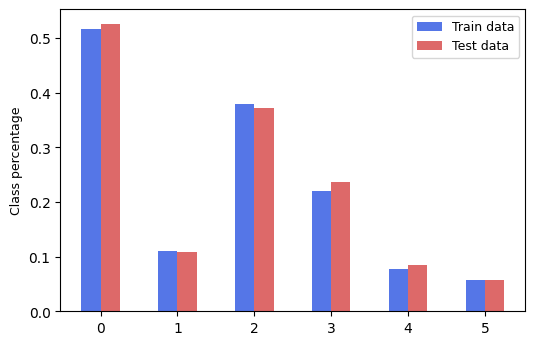

6096
1524


In [ ]:
targets_train = train['final']
targets_test = test['final']

# Calculate class distributions
class_distribution_train = pd.value_counts(targets_train) / len(targets_train)
class_distribution_test = pd.value_counts(targets_test) / len(targets_test)

class_distribution_train = [class_distribution_train[i] for i in range(len(class_names))]
class_distribution_test = [class_distribution_test[i] for i in range(len(class_names))]

class_distribution_train_ml = np.sum(train_options, axis=0).astype(np.int32) / len(train)
class_distribution_test_ml = np.sum(test_options, axis=0).astype(np.int32) / len(test)

fig = plt.figure()
axs = plt.gca()

fig.set_dpi(100)

width = 0.25
x = np.arange(len(class_names))
plt.bar(x - width/2, class_distribution_train, width, label='Train data', color="#5576e7")
plt.bar(x + width/2, class_distribution_test, width, label='Test data', color="#dd6969")

axs.set_ylabel('Class percentage', size = 9)
plt.legend(loc="upper right", prop={'size': 9})
plt.show()

fig = plt.figure()
axs = plt.gca()

fig.set_dpi(100)

plt.bar(x - width/2, class_distribution_train_ml, width, label='Train data', color="#5576e7")
plt.bar(x + width/2, class_distribution_test_ml, width, label='Test data', color="#dd6969")

axs.set_ylabel('Class percentage', size = 9)
plt.legend(loc="upper right", prop={'size': 9})
plt.show()

print(len(targets_train))
print(len(targets_test))

In [ ]:
!nvidia-smi

In [ ]:
# Select the model that should be used for training/hyperparameter search
use_version = "uklfr/gottbert-base"

# Create dict that contains settings for different models
# opt_max_length was calculated beforehand. Lowering the max sentence length (tokens count after tokenization) reduces model size and speeds up training
version_desc = {}
version_desc["deepset/gbert-base"] = {'short' : "gbert_base", 
                                      'dim' : 768, 
                                      'opt_max_length' : 168,
                                      'batch_size' : 32, 
                                      'epochs' : 5,
                                      'learning_rate' : 4e-5}

version_desc["deepset/gbert-large"] = {'short' : "gbert_large", # 195, 230
                                       'dim' : 1024, 
                                       'opt_max_length' : 168,
                                       'batch_size' : 48,
                                       'epochs' : 6,
                                       'learning_rate' : 2e-5}

version_desc["deepset/gelectra-large"] = {'short' : "gelectra_large", 
                                          'dim' : 1024, 
                                          'opt_max_length' : 168,
                                          'batch_size' : 32,
                                          'epochs' : 5,
                                          'learning_rate' : 3e-5}

version_desc["uklfr/gottbert-base"] = {'short' : "gottbert_base", # 180, 240
                                       'dim' : 768, 
                                       'opt_max_length' : 161,
                                       'batch_size' : 16,
                                       'epochs' : 4,
                                       'learning_rate' : 2e-5}

 Preprocess data
 ---

In [ ]:
from datasets import Dataset

# Create datasets using the huggingface Dataset class
train_ds = Dataset.from_pandas(pd.DataFrame({'text': train['sentence'], 
                                             'label': train['final'],
                                             'op0' : train_options[:, 0],
                                             'op1' : train_options[:, 1],
                                             'op2' : train_options[:, 2],
                                             'op3' : train_options[:, 3],
                                             'op4' : train_options[:, 4],
                                             'op5' : train_options[:, 5]}))

labels = [label for label in train_ds.features.keys() if label not in ['text', 'label']]

id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [ ]:
print(train_ds)

Dataset({
    features: ['text', 'label', 'op0', 'op1', 'op2', 'op3', 'op4', 'op5'],
    num_rows: 6096
})


In [ ]:
# Tokenizes a sentence with the globally defined tokenizer
def tokenize_function(sentence):
    tokenized = tokenizer(sentence['text'], padding="max_length")

    # add labels
    labels_batch = {k: sentence[k] for k in sentence.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(sentence['text']), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    tokenized["labels"] = labels_matrix.tolist()
    return tokenized

# Load or generate tokenized sentences
generate_datasets = True
if generate_datasets:
    # tokenizer = AutoTokenizer.from_pretrained(os.path.join(path_models, version_desc[use_version]["short"] + "_tokenizer"))
    tokenizer = AutoTokenizer.from_pretrained(use_version, cache_dir=path_cache, model_max_length=version_desc[use_version]['opt_max_length']) # This line can be used alternatively to download the tokenizer from huggingface

    # Map the function onto the dataset and create a dataset that contains input_ids and attention_mask for each sentence
    tokenized_train = train_ds.map(tokenize_function, batched=True)

    tokenized_train.save_to_disk(os.path.join(path_prep, version_desc[use_version]['short'] + "_train_dataset"))

tokenized_train = Dataset.load_from_disk(os.path.join(path_prep, version_desc[use_version]['short'] + "_train_dataset"))

Length distribution
---
Print Token length distribution

In [ ]:
lens = []
for i in range(len(tokenized_train)):
    lens.append(np.sum(tokenized_train[i]['attention_mask']))

print("Max length", np.max(lens))
plt.hist(lens, 100)
plt.show()

Metrics
---

In [ ]:
from datasets import load_metric
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

metric = load_metric("accuracy")

# Metric for training
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def multi_label_compute_metrics(eval_pred):
    preds = eval_pred.predictions[0] if isinstance(eval_pred.predictions, 
            tuple) else eval_pred.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=eval_pred.label_ids)
    return result

Model Training
---

In [ ]:
from transformers import Trainer, TrainingArguments, TrainerCallback, AutoModelForSequenceClassification, EarlyStoppingCallback
from datasets import concatenate_datasets

use_multilabel = True

# The Trainer class needs a function for model initialization to assure reproducibility
def model_init():
    if use_multilabel:
        return AutoModelForSequenceClassification.from_pretrained(use_version, 
                                                                  num_labels=6,
                                                                  problem_type="multi_label_classification",
                                                                  id2label=id2label,
                                                                  label2id=label2id, 
                                                                  cache_dir=path_cache)
    else:
        return AutoModelForSequenceClassification.from_pretrained(use_version, num_labels=6, cache_dir=path_cache)

data_train = None

# Remove irellevant columns so the trainer can handle the dataset
if use_multilabel:
    data_train = tokenized_train.remove_columns(["text", "label", "op0", "op1", "op2", "op3", "op4", "op5"])
else:
    data_train = tokenized_train.remove_columns(["text", "labels", "op0", "op1", "op2", "op3", "op4", "op5"])

targets = tokenized_train['label']

# Load model settings
epochs = version_desc[use_version]['epochs']
batch_size = version_desc[use_version]['batch_size']
learning_rate = version_desc[use_version]['learning_rate']

print("Epochs:", epochs)
print("Batch size:", batch_size)
print("Learning rate:", learning_rate)

device_count = torch.cuda.device_count()

# Calculate per device batch size
device_batch_size = 16

step_size = 5

eval_delay = int(((len(targets) * 4/5) / batch_size) / step_size) * step_size # Start checkpointing after one epoch
patience = int(((len(targets) * 4/5) / batch_size) / step_size)

print("Eval delay:", eval_delay)
print("Patience:", patience)

for seed in []:

    # Create stratified kfold distributes classes equally
    kfold = StratifiedKFold(5, shuffle=True, random_state=seed)

    train_model = True
    if train_model:
        for index, (fold_train, fold_val) in enumerate(kfold.split(range(len(targets)), targets)):
            if not index in [2, 3, 4]:
                continue
            
            # Folder name where the model gets saved (in the checkpoint or model directory)
            model_name = "{}_finetuned_s{}_cv{}".format(version_desc[use_version]['short'], seed, index) + ("_ml" if use_multilabel else "")

            training_args = TrainingArguments(output_dir=os.path.join(path_checkpoints, model_name), 
                                            overwrite_output_dir=True,
                                            evaluation_strategy='steps',
                                            eval_steps=5, # Evaluate every 5 steps
                                            save_steps=5,
                                            eval_delay=eval_delay,
                                            warmup_steps=16,
                                            learning_rate=learning_rate,
                                            save_strategy='steps',
                                            save_total_limit=1,
                                            seed=seed,
                                            load_best_model_at_end=True,
                                            num_train_epochs=epochs,
                                            per_device_train_batch_size=device_batch_size,
                                            per_device_eval_batch_size=device_batch_size,
                                            gradient_accumulation_steps=batch_size//(device_batch_size * device_count),
                                            gradient_checkpointing=False)

            # Select samples from the training fold
            train_split = data_train.select(fold_train)

            # Select samples from the validation fold
            val_split = data_train.select(fold_val)

            trainer = Trainer(model_init=model_init, 
                            args=training_args, 
                            train_dataset=train_split, 
                            eval_dataset=val_split,
                            compute_metrics=multi_label_compute_metrics if use_multilabel else compute_metrics,
                            callbacks=[EarlyStoppingCallback(patience)])
            
            # Start training
            trainer.train()
            
            # Save the best model (weights get restored to the best model after training)
            trainer.model.save_pretrained(os.path.join(path_models, model_name))

Epochs: 4
Batch size: 16
Learning rate: 2e-05
Eval delay: 300
Patience: 60


Hyperparameter Search
---

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
from transformers import AutoModelForSequenceClassification
from datasets import concatenate_datasets

# Create stratified kfold distributes classes equally
kfold = StratifiedKFold(5, shuffle=True, random_state=0)

# The Trainer class needs a function for model initialization to assure reproducibility
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(use_version, num_labels=6, cache_dir=path_cache)

data_train = tokenized_train

# Used for data splitting
targets = data_train['label']

device_count = torch.cuda.device_count()

# Calculate per device batch size
device_batch_size = 16

seed = 0

for batch_size in [16, 32, 48, 64]:
    for learning_rate in [1e-5, 2e-5, 3e-5, 4e-5]:
        for index, (fold_train, fold_val) in enumerate(kfold.split(range(len(targets)), targets)):
            # Folder name where the model gets saved (in the checkpoint or model directory)
            model_name = "search_{}_finetuned_b{}_lr{}_s{}_cv{}".format(version_desc[use_version]['short'], batch_size, learning_rate, seed, index)
            
            training_args = TrainingArguments(output_dir=os.path.join(path_checkpoints, model_name), 
                                                overwrite_output_dir=True,
                                                evaluation_strategy='steps',
                                                eval_steps=5, # Evaluate every 5 steps
                                                warmup_steps=16,
                                                learning_rate=learning_rate,
                                                save_strategy='no',
                                                seed=seed,
                                                num_train_epochs=3 + batch_size // 16,
                                                per_device_train_batch_size=device_batch_size,
                                                per_device_eval_batch_size=device_batch_size,
                                                gradient_accumulation_steps=batch_size//(device_batch_size * device_count),
                                                gradient_checkpointing=False)

            # Select samples from the training fold
            train_split = data_train.select(fold_train)

            # Select samples from the validation fold
            val_split = data_train.select(fold_val)

            trainer = Trainer(model_init=model_init, 
                            args=training_args, 
                            train_dataset=train_split, 
                            eval_dataset=val_split,
                            compute_metrics=compute_metrics)
            
            # Start training
            trainer.train()
            
            # Save the best model (weights get restored to the best model after training)
            trainer.model.save_pretrained(os.path.join(path_models, model_name))

            break

Prediction
---

In [ ]:

def pred_sentences(sentences, tokenizer, model):
    '''
    Make predictions for a list of sentences. Using this function with too many sentences may cause out-of-memory errors.
    '''

    tokenized = tokenizer(sentences, padding="longest", truncation=True)
    
    input_ids = torch.IntTensor(tokenized['input_ids']).to('cuda:0')
    attention_mask = torch.IntTensor(tokenized['attention_mask']).to('cuda:0')

    with torch.no_grad():
        preds = np.exp(model.forward(input_ids, attention_mask=attention_mask).logits.cpu().detach().numpy())
        preds /= np.sum(preds, axis=1, keepdims=True)

    return preds


Generate OOF predictions
---

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
from transformers import AutoModelForSequenceClassification
from datasets import concatenate_datasets
from tqdm import tqdm

# Used for data splitting
targets = train['final']

version_use_multilabel = [True]
version_seed = [0]

# Set parameters to generate out-of-fold predictions for certain model, seed combinations
for index, model_version in enumerate(['uklfr/gottbert-base']):

    # Create stratified kfold distributes classes equally
    kfold = StratifiedKFold(5, shuffle=True, random_state=version_seed[index])

    oof_preds = np.zeros((len(train), 6))

    # Predict for each fold
    for fold_index, (fold_train, fold_val) in enumerate(kfold.split(range(len(targets)), targets)):

        model_preds = []

        model_name = f"{version_desc[model_version]['short']}_finetuned_s{version_seed[index]}_cv{fold_index}" + ("_ml" if version_use_multilabel[index] else "")

        tokenizer = AutoTokenizer.from_pretrained(model_version, cache_dir=path_cache, model_max_length=version_desc[model_version]['opt_max_length'])
        model = AutoModelForSequenceClassification.from_pretrained(os.path.join(path_models, model_name))
        model.to('cuda:0')

        step_size = 16

        val_sentences = np.array(train['sentence'])[fold_val] # Predict for the validation fold

        for i in tqdm(range(0, len(val_sentences), step_size)):
            model_preds.append(pred_sentences(list(val_sentences[i:i+step_size]), tokenizer, model))

        model_preds = np.concatenate(model_preds)

        # Set oof preds for the current fold
        oof_preds[fold_val] = model_preds

        model.to('cpu')

        del model

    np.save(os.path.join(path_prep, f"oof_{version_desc[model_version]['short']}_s{version_seed[index]}" + ("_ml" if version_use_multilabel[index] else "") + ".npy"), oof_preds)

Generate Test predictions
---

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
from transformers import AutoModelForSequenceClassification
from datasets import concatenate_datasets
from tqdm import tqdm

# 20 minutes

test = pd.read_csv(path_test, sep='\t')

# Set parameters to generate predictions for certain model, seed combinations
version_use_multilabel = [False, False, False, False, False, False, False, False, False]
version_seed = [0, 0, 0, 0, 1, 1, 1, 2, 3]

for index, model_version in enumerate(['deepset/gbert-base', 'deepset/gbert-large', 'deepset/gelectra-large', 'uklfr/gottbert-base', 'deepset/gbert-base', 'deepset/gbert-large', 'uklfr/gottbert-base', 'deepset/gbert-large', 'deepset/gbert-large']):

    print("Pred model", model_version)

    test_preds = np.zeros((len(test), 6))
        
    # Predict for each fold
    for fold_index in range(5):
        print("Pred fold", fold_index)
        model_preds = []

        model_name = f"{version_desc[model_version]['short']}_finetuned_s{version_seed[index]}_cv{fold_index}" + ("_ml" if version_use_multilabel[index] else "")

        tokenizer = AutoTokenizer.from_pretrained(model_version, cache_dir=path_cache, model_max_length=version_desc[model_version]['opt_max_length'])
        model = AutoModelForSequenceClassification.from_pretrained(os.path.join(path_models, model_name))
        model.to('cuda:0') # Use GPU

        step_size = 16

        test_sentences = np.array(test['sentence'])

        for i in tqdm(range(0, len(test_sentences), step_size)):
            model_preds.append(pred_sentences(list(test_sentences[i:i+step_size]), tokenizer, model))

        model_preds = np.concatenate(model_preds)

        test_preds += model_preds / 5 # Divide by 5, since there are 5 folds

        model.to('cpu')

        del model # Destruct object afterwards

    np.save(os.path.join(path_prep, f"testpreds_{version_desc[model_version]['short']}_s{version_seed[index]}" + ("_ml" if version_use_multilabel[index] else "") + ".npy"), test_preds)

Train Ensemble Stack
---

In [ ]:
def get_ensemble_model(is_multilabel, seed=0):
    '''
    This model calculates a weighted average of the different predictions. 
    It also transforms the character length into a seperate output distribution and ensembles it with the rest of the models, 
    with a learned weight that depends on the character length.
    '''

    tf.random.set_seed(seed)

    model_count = 5 if is_multilabel else 9

    input_preds = Input((model_count, 6))
    input_len = Input(1, dtype=tf.float32)

    len_feature = tf.math.log(tf.clip_by_value(input_len, 1, 1000)) / tf.math.log(float(4)) # Log transforming length worked out to be good for validation loss

    if not is_multilabel:
        len_feature = tf.one_hot(tf.clip_by_value(tf.cast(len_feature[:, 0], tf.int32), 0, 4), depth=5) # For multiclass, using a one_hot for differnt length bins was performing slightly better on the validation data

    batch_size = K.shape(input_preds)[0]
    constant = tf.constant([[1]])
    constant = K.tile(constant, (batch_size, 1))

    weights = layers.Dense(model_count, activation="softmax")(constant) # Weights for the models

    features = input_preds

    wavg = tf.reduce_sum(features * tf.expand_dims(weights, -1), axis=1)

    dense_len = layers.Dense(64)(len_feature)
    dense_len = layers.Dense(6, activation="sigmoid" if is_multilabel else "softmax")(dense_len)
    weights_len = layers.Dense(2, activation="softmax")(dense_len) # Weights for amount of influence of the transformed length feature

    stack = tf.stack([wavg, dense_len], axis=1)

    output = tf.reduce_sum(stack * tf.expand_dims(weights_len, -1), axis=1)

    model = Model([input_preds, input_len], output)
    model_weights = Model([input_preds, input_len], [weights, weights_len])

    return model, model_weights

In [ ]:
import tensorflow as tf
from keras import layers, callbacks, Model, Input
from keras.optimizer_v2.adam import Adam
import keras.backend as K

ensemble_multilabel = False

oof_pred_files = None

if ensemble_multilabel:
    oof_pred_files = ['oof_gbert_base_s0_ml', 'oof_gbert_large_s0_ml', 'oof_gelectra_large_s0_ml', 'oof_gottbert_base_s0_ml', 'oof_bow_ml']
else:
    oof_pred_files = ['oof_gbert_base_s0', 'oof_gbert_large_s0', 'oof_gelectra_large_s0', 'oof_gottbert_base_s0', 'oof_gbert_base_s1', 'oof_gbert_large_s1', 'oof_gottbert_base_s1', 'oof_gbert_large_s2', 'oof_gbert_large_s3']

train_oof_preds = np.transpose(np.array([np.load(os.path.join(path_prep,  file_name + ".npy")) for file_name in oof_pred_files]), (1, 0, 2))


'''

Logloss decimals for mutliclass ensembles

50/50 - 50% validation data
100/0 - validation data is equal to training data

['oof_gbert_large_s0']
50/50 [1] 0.8888
100/0 [1] 0.9095

['oof_gbert_base_s0', 'oof_gbert_large_s0', 'oof_gelectra_large_s0', 'oof_gottbert_base_s0']
50/50 [0.2215345  0.41411024 0.18046807 0.18388718] - 0.8583
100/0 [0.25385952 0.44881278 0.13013093 0.16719678] - 0.8722

['oof_gbert_base_s0', 'oof_gbert_large_s0', 'oof_gelectra_large_s0', 'oof_gottbert_base_s0', 'oof_gbert_large_s1']
50/50 [0.1725647  0.28480768 0.11399592 0.1163224  0.31230935] - 0.8553
100/0 [0.20551509 0.34115565 0.07937698 0.11557036 0.25838187] - 0.8657 

['oof_gbert_base_s0', 'oof_gbert_large_s0', 'oof_gelectra_large_s0', 'oof_gottbert_base_s0', 'oof_gbert_base_s1', 'oof_gbert_large_s1']
50/50 [0.13003656 0.27313623 0.10346217 0.09601243 0.10856576 0.28878686] - 0.8544
100/0 [0.16272582 0.32965577 0.07056338 0.09542985 0.10735414 0.23427103] - 0.8647

['oof_gbert_base_s0', 'oof_gbert_large_s0', 'oof_gelectra_large_s0', 'oof_gottbert_base_s0', 'oof_gbert_base_s1', 'oof_gbert_large_s1', 'oof_gottbert_base_s1']
50/50 [0.12393897 0.27173993 0.09739704 0.07073774 0.09619309 0.2755412 0.06445203] - 0.8532
100/0 [0.15480751 0.32888326 0.0601825  0.05806786 0.08838687 0.2140342 0.09563776] - 0.8638

['oof_gbert_base_s0', 'oof_gbert_large_s0', 'oof_gelectra_large_s0', 'oof_gottbert_base_s0', 'oof_gbert_base_s1', 'oof_gbert_large_s1', 'oof_gottbert_base_s1'] + lens
50/50 [0.12921269 0.27060598 0.08928902 0.06293467 0.0976179  0.28366733 0.06667238] - 0.8528
100/0 [0.157343   0.32895178 0.05166753 0.05015953 0.09013588 0.22032179 0.10142051] - 0.8632

['oof_gbert_base_s0', 'oof_gbert_large_s0', 'oof_gelectra_large_s0', 'oof_gottbert_base_s0', 'oof_gbert_base_s1', 'oof_gbert_large_s1', 'oof_gottbert_base_s1', 'oof_gbert_large_s2', 'oof_gbert_large_s3'] + lens
50/50 [0.07971746 0.16366951 0.04102142 0.04202948 0.05954136 0.18033294 0.03889816 0.20319907 0.19159062] - 0.8479
100/0 [0.11047547 0.22762994 0.0141276  0.02801014 0.06698895 0.13231237 0.07156801 0.16253692 0.18635057] - 0.8567

Logloss decimals for mutlilabel ensembles

['oof_gbert_base_s0_ml', 'oof_gbert_large_s0_ml', 'oof_gelectra_large_s0_ml', 'oof_gottbert_base_s0_ml', 'oof_bow_ml']
50/50 [0.18560362 0.3340512  0.2523616  0.07471658 0.15326703] 0.3101
100/0 [0.23947793 0.35905367 0.20459546 0.05041973 0.14645328] 0.3155
'''

lens = []

for i, row in train.iterrows():
    lens.append(len(row["sentence"]))

lens = np.array(lens)

model, model_weights = get_ensemble_model(ensemble_multilabel)
model.compile(loss="binary_crossentropy" if ensemble_multilabel else "sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

targets = train_options if ensemble_multilabel else np.array(train['final'])

cb_early_stopping = callbacks.EarlyStopping(patience=40, min_delta=5e-5, restore_best_weights=True)

model.fit(x=[train_oof_preds, lens],
          y=targets,
          validation_data=([train_oof_preds, lens], targets), # Use this for final training. Unlikely to overfit since model complexity is very low and min_delta parameter is used for early stopping
          #validation_split=0.5, # Use this for hyperparamter testing
          epochs=1000,
          batch_size=128,
          callbacks=[cb_early_stopping])


multilabel_str = "_ml" if ensemble_multilabel else ""
model.save_weights(os.path.join(path_models, f"stack_model{multilabel_str}.h5"))

print(model_weights.predict([train_oof_preds[:1], lens[:1]])[0][0])

Evaluation
---

In [ ]:
from scipy.special import softmax
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, average_precision_score, hamming_loss, jaccard_score, accuracy_score
import seaborn as sns

def evaluate(y_true_max, y_pred, is_max=False):
    '''
    Evaluate and plot metrics for given predictions and targets. If is_max is False, y_pred contains probabilities.
    '''
    y_pred_max = None
    if is_max:
        y_pred_max = y_pred
    else:
        y_pred_max = np.argmax(y_pred, axis=1)

    y_true_discrete = np.zeros(y_pred.shape, dtype=np.uint8)
    y_pred_discrete = np.zeros(y_pred.shape, dtype=np.uint8)

    y_true_discrete[y_true_max] = 1
    y_pred_discrete[y_pred_max] = 1

    # Calculate various metrics
    micro_f1 = metrics.f1_score(y_true_max, y_pred_max, average='micro')
    macro_f1 = metrics.f1_score(y_true_max, y_pred_max, average='macro')
    accuracy = metrics.accuracy_score(y_true_max, y_pred_max)
    cohens_kappa = metrics.cohen_kappa_score(y_true_max, y_pred_max)
    confusion_matrix = metrics.confusion_matrix(class_names[y_true_max], class_names[y_pred_max], labels=class_names)
    log_loss = None
    
    if not is_max:      
        log_loss = np.mean(-np.log(y_pred[np.arange(len(y_pred)), y_true_max]))
    
    print("Micro f1:     {:.6f}".format(micro_f1))
    print("Macro f1:     {:.6f}".format(macro_f1))
    print("Cohens kappa: {:.6f}".format(cohens_kappa))
    print("Log loss:     {:.6f}".format(log_loss))

    # Plot confusion matrix
    ax = plt.subplot()

    fig = plt.gcf()
    fig.set_dpi(100)

    sns.heatmap(confusion_matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(list(class_names), rotation=45, ha='right', rotation_mode='anchor')
    ax.yaxis.set_ticklabels(list(class_names), rotation=0)
    
    plt.show()

    return micro_f1, macro_f1, cohens_kappa, log_loss

def evaluate_multilabel(y_true, y_pred):
    '''
    Evaluate and plot metrics for given predictions and targets. If is_max is False, y_pred contains probabilities.
    '''

    y_pred_discrete = np.rint(y_pred)

    # Calculate various metrics

    micro_f1 = f1_score(y_true, y_pred_discrete, average='weighted')
    avg_prec = average_precision_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred_discrete)
    jaccard = jaccard_score(y_true, y_pred_discrete, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_discrete)
    log_loss = (np.sum(-np.log(y_pred[y_true == 1])) + np.sum(-np.log(1-y_pred[y_true == 0]))) / (y_true.shape[0] * y_true.shape[1])

    print("Micro f1:        {:.6f}".format(micro_f1))
    print("Avg precision:   {:.6f}".format(avg_prec))
    print("Hamming loss:    {:.6f}".format(hamming))
    print("Jaccard:         {:.6f}".format(jaccard))
    print("Subset accuracy: {:.6f}".format(accuracy))
    print("Log loss:        {:.6f}".format(log_loss))

    return micro_f1, avg_prec, hamming, jaccard, accuracy, log_loss

Evaluate Test Set
---

In [ ]:
import tensorflow as tf
from keras import layers, callbacks, Model, Input
from keras.optimizer_v2.adam import Adam
import keras.backend as K

# Files (with the correct order) to train the oof stack model
testpred_files = ['testpreds_gbert_base_s0',
                  'testpreds_gbert_large_s0',
                  'testpreds_gelectra_large_s0',
                  'testpreds_gottbert_base_s0',
                  'testpreds_gbert_base_s1',
                  'testpreds_gbert_large_s1',
                  'testpreds_gottbert_base_s1',
                  'testpreds_gbert_large_s2',
                  'testpreds_gbert_large_s3']

testpreds = np.transpose(np.array([np.load(os.path.join(path_prep, file_name + ".npy")) for file_name in testpred_files]), (1, 0, 2))

test_lens = []

for i, row in test.iterrows():
    test_lens.append(len(row["sentence"]))

test_lens = np.array(test_lens)
targets = np.array(test['final'], dtype=np.int32)

model, model_weights = get_ensemble_model(False)

model.load_weights(os.path.join(path_models, "stack_model.h5"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

model.evaluate([testpreds, test_lens], targets, batch_size=512)
stack_testpreds = model.predict([testpreds, test_lens], batch_size=512)

all_metrics = []

# Evaluate all models and the ensemble
for i in range(testpreds.shape[1]):
    print("EVALUATE", testpred_files[i])
    all_metrics.append([*evaluate(targets, testpreds[:, i])])

print("EVALUTAE bow")
all_metrics.append([*evaluate(targets, np.load(os.path.join(path_prep, "testpreds_bow.npy")))])

print("EVALUTAE ensemble")
all_metrics.append([*evaluate(targets, stack_testpreds)])

In [ ]:
import tensorflow as tf
from keras import layers, callbacks, Model, Input
from keras.optimizer_v2.adam import Adam
import keras.backend as K

# Files (with the correct order) to train the oof stack model
testpred_files_ml = ['testpreds_gbert_base_s0_ml',
                     'testpreds_gbert_large_s0_ml',
                     'testpreds_gelectra_large_s0_ml',
                     'testpreds_gottbert_base_s0_ml',
                     'testpreds_bow_ml']

testpreds_ml = np.transpose(np.array([np.load(os.path.join(path_prep,  file_name + ".npy")) for file_name in testpred_files_ml]), (1, 0, 2))

test_lens = []

for i, row in test.iterrows():
    test_lens.append(len(row["sentence"]))

test_lens = np.array(test_lens)
targets = test_options

model, model_weights = get_ensemble_model(True)

model.load_weights(os.path.join(path_models, "stack_model_ml.h5"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

model.evaluate([testpreds_ml, test_lens], targets, batch_size=512)
stack_testpreds_ml = model.predict([testpreds_ml, test_lens], batch_size=512)

all_metrics = []

for i in range(testpreds_ml.shape[1]):
    print("EVALUATE", testpred_files_ml[i])
    all_metrics.append([*evaluate_multilabel(targets, testpreds_ml[:, i])])

print("EVALUTAE ensemble")
all_metrics.append([*evaluate_multilabel(targets, stack_testpreds_ml)])
